# A qualitative example of Self-Attention in the Transformer Model

This notebook instantiates a Transformer model, loads pre-trained weights and visualizes internal states by adding `hooks` to several attention layers to visualize results and store internal states

We trained a transformer model for crop type classification from Satellite time series. This notebook qualitatively analyses the self-attention activations which form the core mechanic of the Transformer model. 

![](doc/self-attention.png)

The weights $\theta$ are trained via gradient backpropagation


In [1]:
import sys
import os

# get the files if executed in colab
if not os.path.exists("requirements.txt"):
  !git clone https://github.com/MarcCoru/phiweek19 /tmp/repo
  !mv /tmp/repo/* .

!pip install -r requirements.txt

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from TransformerEncoder import TransformerEncoder
import torch
import tqdm
import pandas as pd

BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9']

sns.set_style("whitegrid")

# simulate no GPU (for checks like torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"] = ""


def totorch(x):
    """single numpy array (txd) to torch batch (1xdxt)"""
    x = torch.Tensor(x).unsqueeze(0).transpose(1,2)
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x

## Data

### Data Partitioning

The models were trained on the trainset of the HOLL region.
This notebook loads data exclusively from test partitions of the HOLL region and a spatially different KRUM region. Change the parameter `region=holl` to `region=krum` to change the data region

In [2]:
# Test Partition of the HOLL region (model was trained on the Train Partition on the HOLL region)
region = "holl" # <- change to 'krum' for test data from a different region

if region == "holl":
    X = np.load("data/x.npy")
    y = np.load("data/y.npy")
    meta = np.load("data/meta.npy")
elif region == "krum":
    # Test Partition of the KRUM region
    X = np.load("data/x_krum.npy")
    y = np.load("data/y_krum.npy")
    meta = np.load("data/meta_krum.npy")

klassennamen = np.load("data/classnames.npy", allow_pickle=True)
classnames = klassennamen

print(f"X shape: (N, T, D):{X.shape} with N examples, sequencelength T, and D number of features per t")
print(f"y shape: (N, C):{y.shape} with N examples, sequencelength T (class repeatet T times)")
print()
print("classes (in german)")
print("")
print("\n".join(classnames))

X shape: (N, T, D):(100, 50, 13) with N examples, sequencelength T, and D number of features per t
y shape: (N, C):(100, 50) with N examples, sequencelength T (class repeatet T times)

classes (in german)

Stilllegungen
Stilllegungen mit Blühpflanzen
Klee- u./o. Luzernen u./o. Eiweißpflanzen
Gräser
Wintergemenge
Sommergemenge
Eiweißpflanzengemenge
Winterweizen
Mais
Sommerweizen
Rüben
Kartoffeln
Stilllegungen DG
DG mit Maschineneinsatz
DG mitViehbesatz
Silphium
Miscanthus
Niederwald
Winterdinkel
Winterroggen, Winter-Waldstaudenroggen
Wintergerste
Sommergerste
Sommerhafer
Wintertriticale
Sommertriticale
Erbsen (ÖVF)
Ackerbohnen (ÖVF)
Winterraps
Sojabohnen (ÖVF)
GPS Winterweichweizen
GPS Winterroggen
GPS Wintermenggetreide ohne Weizen
GPS Sommerhafer
GPS Wintertriticale
GPS Gemenge Körnerleguminosen mit Stützfrucht (ÖVF)
Erdbeeren
Beerenobst, z. B. Johannis-, Stachel-, Heidel- und Himbeeren
Grünbrache im ökologischen Landbau (Hauptfutterfläche)
Maximal 3 Jahre nichtlandwirtschaftlich genu

## Choose one Example for this Analysis

Text(0, 0.5, 'Time index t (from January to December)')

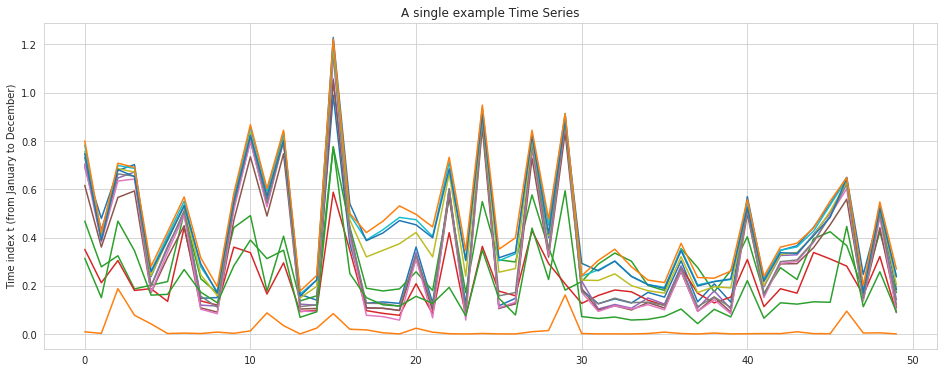

In [3]:
idx = 0 # <- change this to an index between 0 and N=99

# model was trained on the train partition on the holl region
x = X[idx]
y = y[idx]


fld=os.path.join("data/transformer")
os.makedirs(fld,exist_ok=True)

df = pd.DataFrame(x, columns=BANDS)
df.index.name="t"
df.to_csv(os.path.join(fld,"x.csv"))

np.savetxt(fld+"/x.txt", x, fmt="%.4f")

fig, ax = plt.subplots(1,figsize=(16,6))
ax.plot(x)
ax.set_title("A single example Time Series")
ax.set_ylabel("Reflectance")
ax.set_ylabel("Time index t (from January to December)")

## Initialize a Transformer model

In [4]:
hidden_dims = 128
n_heads = 3
n_layers = 3
dropout=0.262039
d_inner = hidden_dims*4
nclasses=34

transformer = TransformerEncoder(in_channels=13, len_max_seq=70,
            d_word_vec=hidden_dims, d_model=hidden_dims, d_inner=d_inner,
            n_layers=n_layers, n_head=n_heads, d_k=hidden_dims//n_heads, d_v=hidden_dims//n_heads,
            dropout=dropout, nclasses=nclasses)

# set transformer to eval mode
transformer.zero_grad()
transformer.eval()

TransformerEncoder(
  (inlayernorm): LayerNorm(torch.Size([13]), eps=1e-05, elementwise_affine=True)
  (convlayernorm): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
  (outlayernorm): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
  (inconv): Conv1d(13, 128, kernel_size=(1,), stride=(1,))
  (encoder): Encoder(
    (position_enc): Embedding(71, 128)
    (layer_stack): ModuleList(
      (0): EncoderLayer(
        (slf_attn): MultiHeadAttention(
          (w_qs): Linear(in_features=128, out_features=126, bias=True)
          (w_ks): Linear(in_features=128, out_features=126, bias=True)
          (w_vs): Linear(in_features=128, out_features=126, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1)
            (softmax): Softmax()
          )
          (layer_norm): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
          (fc): Linear(in_features=126, out_features=128, bias=True)
          (d

## Load Pre-trained Weights

In [5]:
_ = transformer.load("transformer.pth")

loading model from transformer.pth


## Define Hooks to access the internal tensors

In [6]:
tumorange=(0.89019608, 0.44705882, 0.13333333, 1)
tumblue=(0., 0.39607843, 0.74117647,1)
tumred=(0.76862745,  0.28235294,  0.10588235,1)
tumblack=(0,0,0,1)

def attn_plots(ax, arr, mode="conn"):
    assert mode in ["conn","adj"]
    
    if mode =="adj":
        ax.imshow(arr)
        ax.axis('off')
        ax.set_xlabel("out")
        ax.set_ylabel("in")
    
    elif mode=="conn":
        N = arr.shape[1]
        
        ax.set_xlim(0,N)
        for o in tqdm.tqdm(range(N)):
            for i in range(N):
                ax.add_line(Line2D([i,o], [0,1],color=(tumred[0],tumred[1],tumred[2],arr[o,i,0]*.5)))
                #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
                #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
        ax.axis('off')
    return ax
    

def attention_hook(module, inp, out, name):
    print(name)
    
    enc_output, enc_slf_attn = out
    
    # Query, Key, Values <- all the same input for self-attention
    enc_input, enc_input, enc_input = inp
    
    os.makedirs(os.path.join(fld,name),exist_ok=True)
    
    for i in range(enc_slf_attn.shape[0]):
        np.savetxt(os.path.join(fld,name)+"/enc_slf_attn_{}.txt".format(i), enc_slf_attn[i].cpu().detach().numpy(), fmt="%.4f")
        print("writing "+os.path.join(fld,name)+"/enc_slf_attn_{}.txt".format(i))
    np.savetxt(os.path.join(fld,name)+"/enc_output.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    print("writing "+os.path.join(fld,name)+"/enc_output.txt")
    np.savetxt(os.path.join(fld,name)+"/enc_input.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    print("writing "+os.path.join(fld,name)+"/enc_input.txt")
    
    fig,axs = plt.subplots(3,figsize=(12,6))
    axs[0].plot(enc_input[0].cpu().detach().numpy())
    axs[0].set_title("input")
    
    axs[1] = attn_plots(axs[1], enc_slf_attn.transpose(2,0).cpu().detach().numpy(), mode="conn")
    
    axs[1].set_title("attention scores")
    axs[2].set_title("output")
    axs[2].plot(enc_output[0].cpu().detach().numpy())
    
    fig.savefig(os.path.join(os.path.join(fld,name),name+".png"), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(os.path.join(fld,name),name+".png"))
    
def attention1_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-1")
    

def attention2_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-2")
    

def attention3_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-3")
    
    
def outlinear_hook(module, inp, out):
    inp = inp[0].cpu().detach().numpy()
    out = out[0].cpu().detach().numpy()
    print(out.shape)
    fig,ax = plt.subplots(1,figsize=(12,3))
    ax.bar(np.arange(out.shape[0]), np.exp(out))
    ax.set_ylabel("Score")
    ax.set_xlabel("Class")
    
    fig.savefig(os.path.join(fld,"outlinear.png"), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(fld,"outlinear.png"))
    
def inlayernorm_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    
def pos_ffn_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    

##  Attach Hooks to the Transformer Model

In [7]:
transformer.inlayernorm.register_forward_hook(inlayernorm_hook)
transformer.encoder.layer_stack[0].slf_attn.attention.register_forward_hook(attention1_hook)
#transformer.encoder.layer_stack[0].pos_ffn.register_forward_hook(pos_ffn_hook)
transformer.encoder.layer_stack[1].slf_attn.attention.register_forward_hook(attention2_hook)
transformer.encoder.layer_stack[2].slf_attn.attention.register_forward_hook(attention3_hook)
#transformer.outlinear.register_forward_hook(outlinear_hook)

## Forward inference

  0%|          | 0/50 [00:00<?, ?it/s]

self-attention-1
writing data/transformer/self-attention-1/enc_slf_attn_0.txt
writing data/transformer/self-attention-1/enc_slf_attn_1.txt
writing data/transformer/self-attention-1/enc_slf_attn_2.txt
writing data/transformer/self-attention-1/enc_output.txt
writing data/transformer/self-attention-1/enc_input.txt


 20%|██        | 10/50 [00:00<00:00, 90.67it/s]

writing data/transformer/self-attention-1/self-attention-1.png
self-attention-2
writing data/transformer/self-attention-2/enc_slf_attn_0.txt
writing data/transformer/self-attention-2/enc_slf_attn_1.txt
writing data/transformer/self-attention-2/enc_slf_attn_2.txt
writing data/transformer/self-attention-2/enc_output.txt
writing data/transformer/self-attention-2/enc_input.txt


 18%|█▊        | 9/50 [00:00<00:00, 87.91it/s]

writing data/transformer/self-attention-2/self-attention-2.png
self-attention-3
writing data/transformer/self-attention-3/enc_slf_attn_0.txt
writing data/transformer/self-attention-3/enc_slf_attn_1.txt
writing data/transformer/self-attention-3/enc_slf_attn_2.txt
writing data/transformer/self-attention-3/enc_output.txt
writing data/transformer/self-attention-3/enc_input.txt


100%|██████████| 50/50 [00:00<00:00, 71.57it/s]


writing data/transformer/self-attention-3/self-attention-3.png


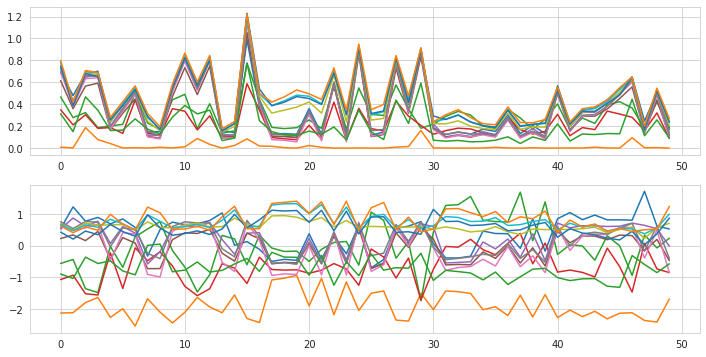

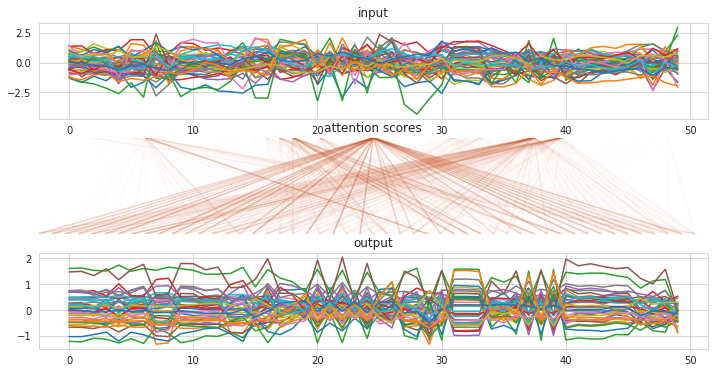

In [ ]:
logprobabilities = transformer.forward(totorch(x))
probas = torch.exp(logprobabilities)

## Further Visualizations

In [ ]:
from matplotlib import cm

path = "data/transformer"

def plot_attention(path, head=0):

    arr0 = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))
    enc_output = np.loadtxt(path+"/enc_output.txt")

    fig, axs = plt.subplots(3,figsize=(16,6))
    sns.despine(ax=axs[0], left=True)
    #sns.despine(ax=axs[1])
    sns.despine(ax=axs[2], left=True)

    axs[0].plot(x)
    axs[0].set_title("Satellite time series of a field parcel")
    axs[0].set_ylabel("Reflectance")
    for o in range(arr0.shape[1]):
        for i in range(arr0.shape[0]):
            axs[1].set_xlim(*axs[0].get_xlim())
            axs[1].set_ylim(-.05,1.05)
            axs[1].add_line(Line2D([i,o], [1,0],marker='|',color=(tumblue[0],tumblue[1],tumblue[2],arr0[o,i])))
            #axs[1].plot([i,o], [1,0],'r', alpha=arr0[o,i]*0.5)
            #axs[1].plot([i,o], [1,0],'g', alpha=arr1[o,i]*0.5)
            #axs[1].plot([i,o], [1,0],'b', alpha=arr2[o,i]*0.5)
    #axs[1].axis('off')
    axs[1].set_yticklabels([])
    axs[1].set_xticklabels([])
    axs[1].set_ylabel("Attention Scores")
    axs[1].set_frame_on(False)
    axs[1].grid(False)

    axs[2].plot(enc_output)
    axs[2].set_ylabel("Extracted Features")
    axs[2].set_xlabel("Time index (January to December)")

    fig.savefig(path+"/attention.png", dpi=300)

plot_attention(path+"/self-attention-1")

In [ ]:
path="data/transformer/self-attention-1"
head=0

for head in [0,1,2]:
    arr0 = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, ax = plt.subplots(1,1, figsize=(8,8))
    s = ax.imshow(arr0.T, cmap="Reds", vmin=0, vmax=1)
    ax.axis('off')
    fig.savefig(os.path.join(path,"head{}_imshow.png".format(head)), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(path,"head0_imshow.png"))
    #fig.colorbar(s)

In [ ]:
arr = arr0.T

color=tumred
for head, color in zip([0,1,2],[tumred, tumblue, tumblack]):
    arr = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, ax = plt.subplots(1, figsize=(16,3))
    N = arr.shape[0]
    ax.set_xlim(0,N)
    
    for t in range(N):
        ax.text(t,1.1,str(t),alpha=0.8, ha='center')
        ax.text(t,-.1,str(t),alpha=0.8, ha='center')
    
    for o in tqdm.tqdm(range(N)):
        for i in range(N):
            
            ax.set_ylim(-.05,1.05)
            ax.add_line(Line2D([i,o], [1,0],marker='o', markersize=5,color=(color[0],color[1],color[2],arr[o,i]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
    ax.axis('off')

    fig.savefig(os.path.join(path,"head{}_conn.png".format(head)), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(path,"head{}_conn.png".format(head)))

In [ ]:
arr = arr0.T

color=tumred
for head, color in zip([0,1,2],[tumred, tumblue, tumblack]):
    arr = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, axs = plt.subplots(2, figsize=(16,6))
    input_focus = arr.sum(0)
    input_focus /= input_focus.max()
    for i in range(len(input_focus)):
        #axs[0].axvline(i, color=(color[0],color[1],color[2],input_focus[i]))
        line=Line2D([i,i], [0,1.2] ,marker='o', markersize=5,color=(color[0],color[1],color[2],input_focus[i]))
        axs[0].add_line(line)
    
    sns.despine(ax=axs[0], left=True)
    axs[0].plot(x)
    axs[0].grid(False)
    axs[0].set_ylabel("input time series")
 
    ax = axs[1]
    ax.set_xlim(*axs[0].get_xlim())
    N = arr.shape[0]
    #ax.set_ylabel("attention scores")
    #ax.set_xlim(0,N)
    for o in tqdm.tqdm(range(N)):
        for i in range(N):
            
            ax.set_ylim(-.05,1.05)
            ax.add_line(Line2D([i,o], [1,0],marker='o', markersize=5,color=(color[0],color[1],color[2],arr[o,i]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
    ax.axis('off')

    fig.savefig(os.path.join(path,"head{}_conn_input.png".format(head)), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(path,"head{}_conn_input.png".format(head)))